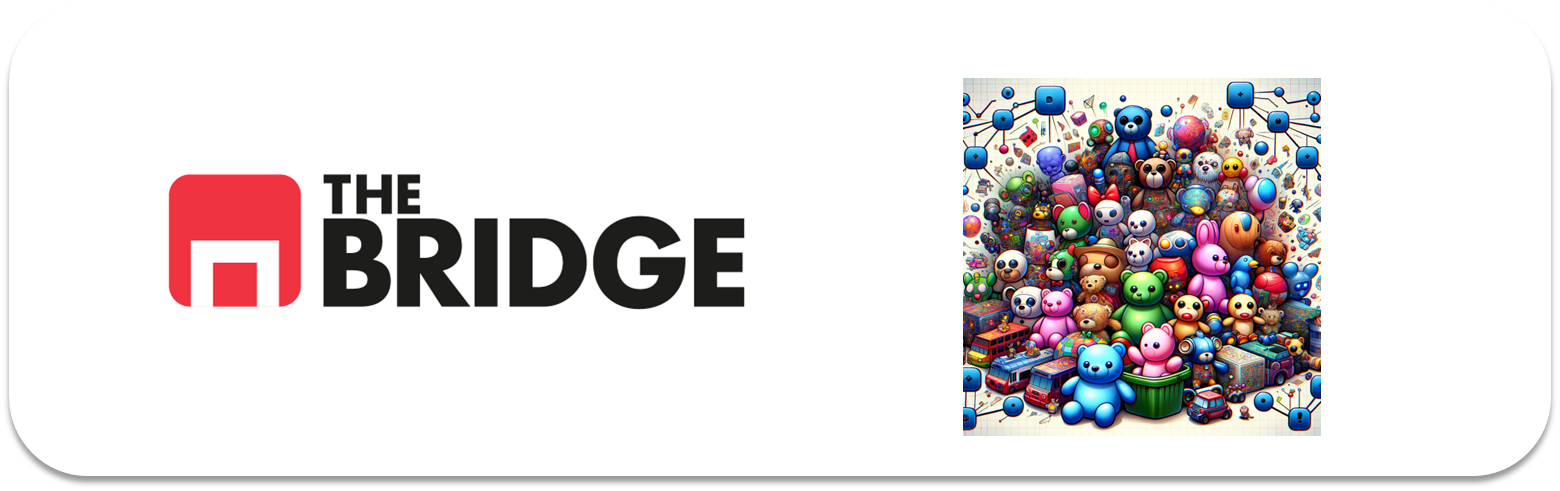

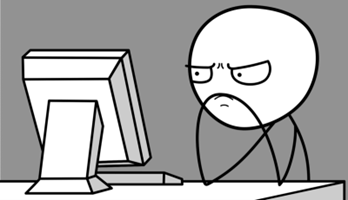

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
# Common imports
import numpy as np
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='b'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=15, linewidths=20,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
     

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [2]:
import pandas as pd

# Cargar los datos desde un archivo CSV
data_path = "./data/empowering_drinks.csv"
df = pd.read_csv(data_path, sep='|')

# Visualizar las primeras filas del dataset
df.head()




,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [3]:
# Resumen estadístico del dataset
df.describe()



,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


In [4]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


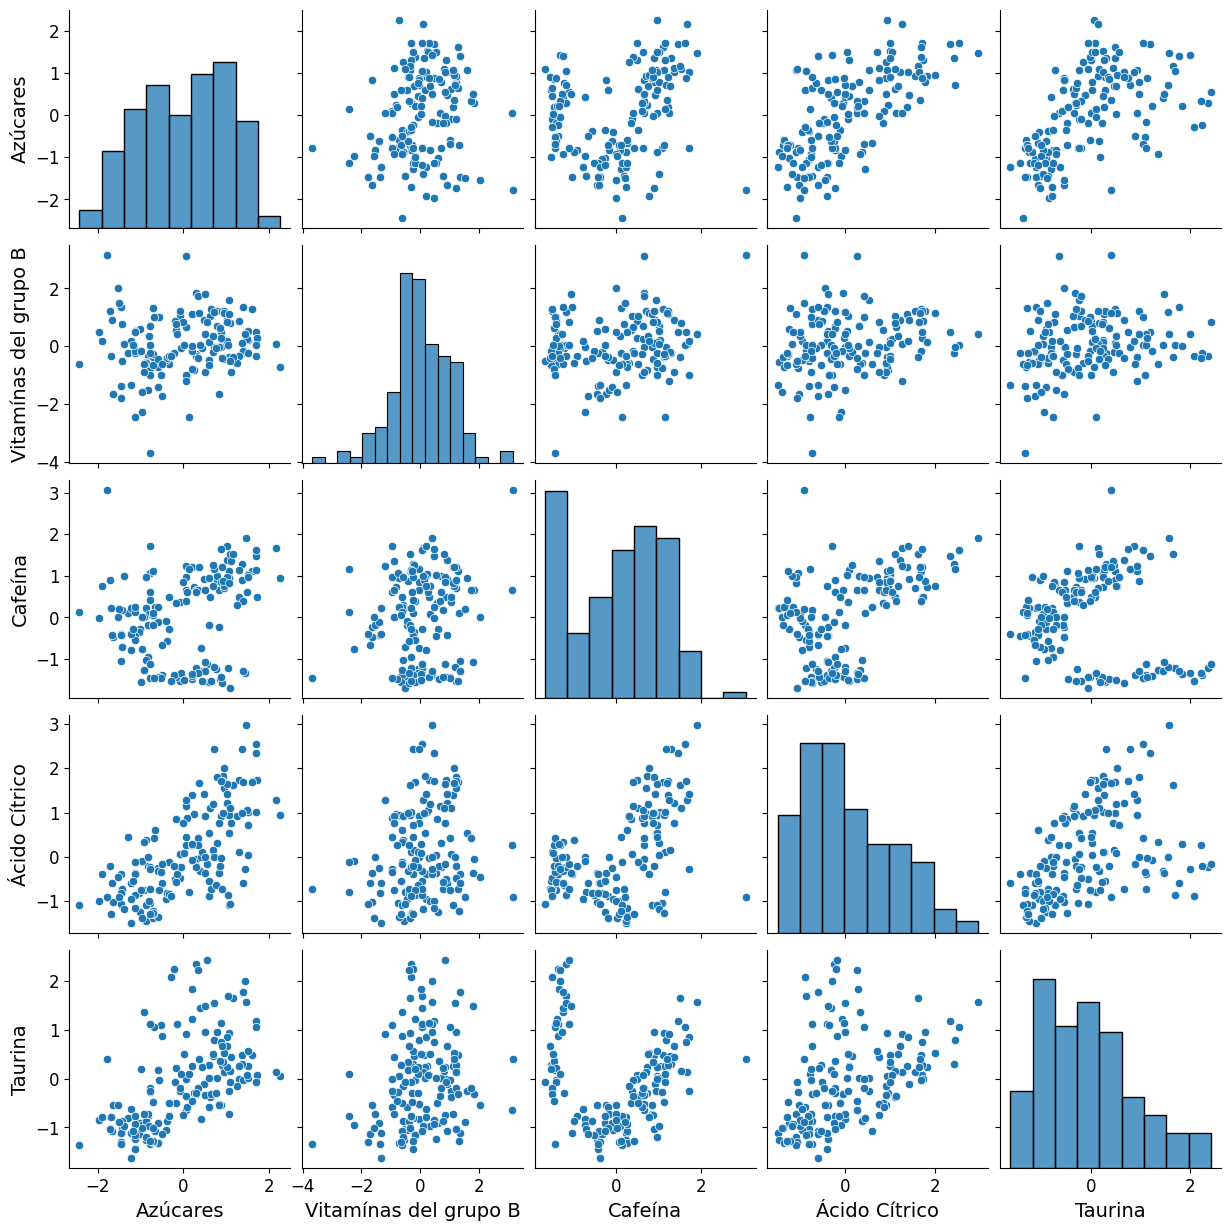

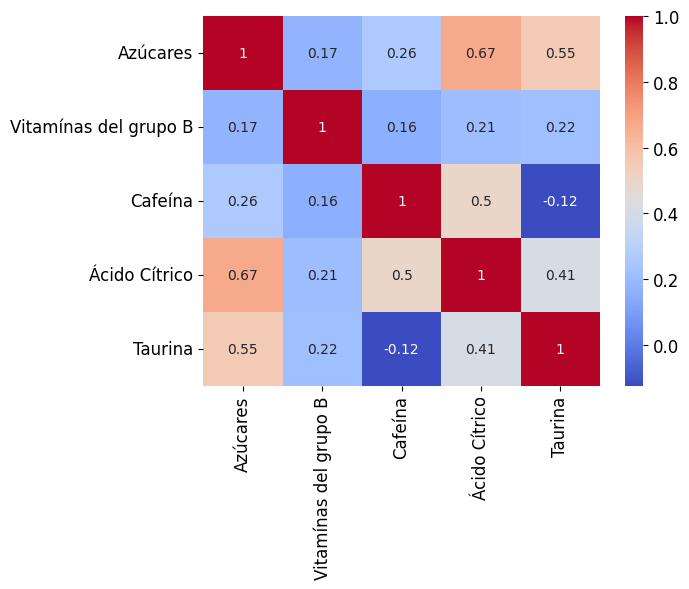

In [5]:
# Visualización pairplot para entender la relación entre las características
sns.pairplot(df)
plt.show()

# Correlación entre las características
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [9]:
print(corr_matrix)

                       Azúcares  Vitamínas del grupo B   Cafeína  \
Azúcares               1.000000               0.174354  0.258166   
Vitamínas del grupo B  0.174354               1.000000  0.155276   
Cafeína                0.258166               0.155276  1.000000   
Ácido Cítrico          0.672969               0.208444  0.497329   
Taurina                0.553245               0.215869 -0.124157   

                       Ácido Cítrico   Taurina  
Azúcares                    0.672969  0.553245  
Vitamínas del grupo B       0.208444  0.215869  
Cafeína                     0.497329 -0.124157  
Ácido Cítrico               1.000000  0.408325  
Taurina                     0.408325  1.000000  


array([[<Axes: title={'center': 'Azúcares'}>,
        <Axes: title={'center': 'Vitamínas del grupo B'}>],
       [<Axes: title={'center': 'Cafeína'}>,
        <Axes: title={'center': 'Ácido Cítrico'}>],
       [<Axes: title={'center': 'Taurina'}>, <Axes: >]], dtype=object)

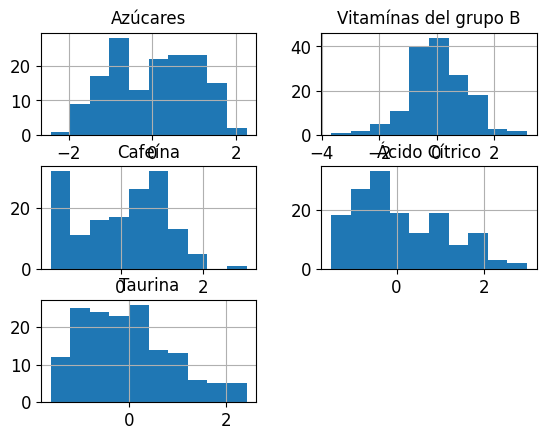

In [10]:
df.hist()

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Probar diferentes valores de k
range_n_clusters = list(range(3, 6))
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    
    silhouette_avg = silhouette_score(df, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")


For n_clusters = 3, the average silhouette score is: 0.3987814788745689
For n_clusters = 4, the average silhouette score is: 0.3634759571660268
For n_clusters = 5, the average silhouette score is: 0.3236089285948519


In [8]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Probar diferentes valores de eps y min_samples
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 15]

best_eps = 0.5
best_min_samples = 10
best_silhouette = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(df)
        
        # Necesitamos al menos 2 clusters para calcular el silhouette score
        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(df, cluster_labels)
            print(f"For eps = {eps} and min_samples = {min_samples}, the average silhouette score is: {silhouette_avg}")
            
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print(f"Best DBSCAN params - eps: {best_eps}, min_samples: {best_min_samples}, silhouette score: {best_silhouette}")



For eps = 0.7 and min_samples = 5, the average silhouette score is: -0.1475689428423885
Best DBSCAN params - eps: 0.7, min_samples: 5, silhouette score: -0.1475689428423885


El puntaje silhouette obtenido con DBSCAN sugiere que los clústeres formados no estan muy bien definidos, ya que el puntaje es negativo. Esto indica que la mayoría de las muestras están mal agrupadas. A pesar de esto, vamos a proceder con la visualización y la comparación de los resultados obtenidos con K-Means y DBSCAN.

In [10]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


# Convertir df a un DataFrame para un mejor manejo
df = pd.DataFrame(df, columns=df.columns)

# Entrenar K-Means
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(df)

# Entrenar DBSCAN con los mejores parámetros encontrados
eps = 0.7
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df)


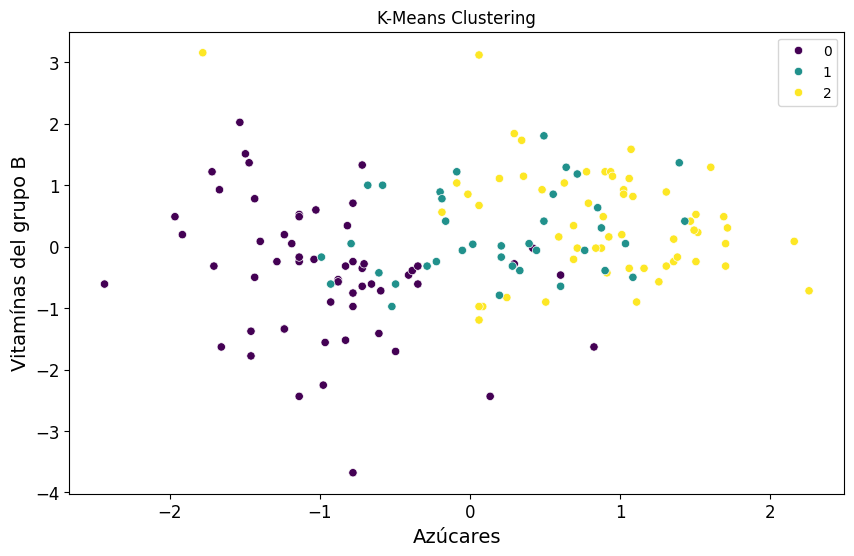

In [16]:
# Visualización de los resultados de K-Means
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Azúcares'], y=df['Vitamínas del grupo B'], hue=kmeans_labels, palette='viridis', legend='full')
plt.title('K-Means Clustering')
plt.xlabel('Azúcares')
plt.ylabel('Vitamínas del grupo B')
plt.show()


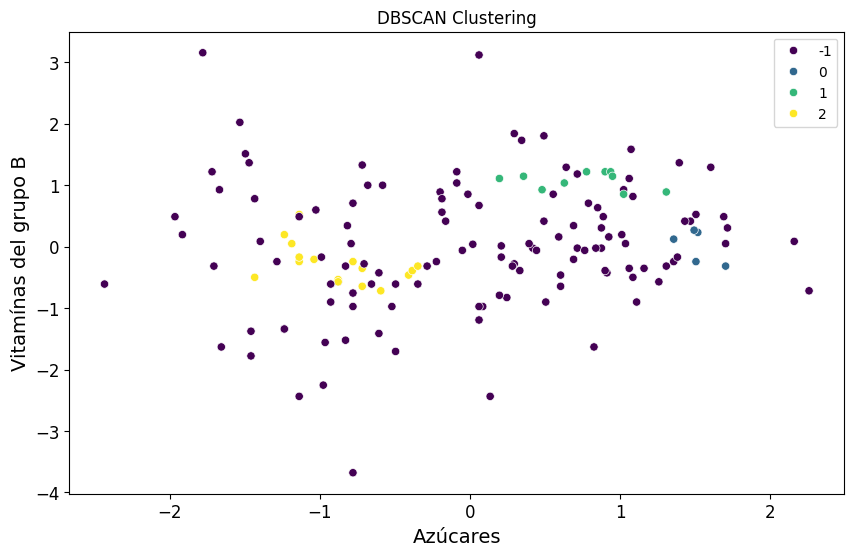

In [15]:
# Visualización de los resultados de DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Azúcares'], y=df['Vitamínas del grupo B'], hue=dbscan_labels, palette='viridis', legend='full')
plt.title('DBSCAN Clustering')
plt.xlabel('Azúcares')
plt.ylabel('Vitamínas del grupo B')
plt.show()


K-Means: 3 clusters
DBSCAN: 4 clusters (incluyendo ruido)
kmeans_cluster
2    58
0    58
1    37
Name: count, dtype: int64
dbscan_cluster
-1    122
 2     16
 1     10
 0      5
Name: count, dtype: int64


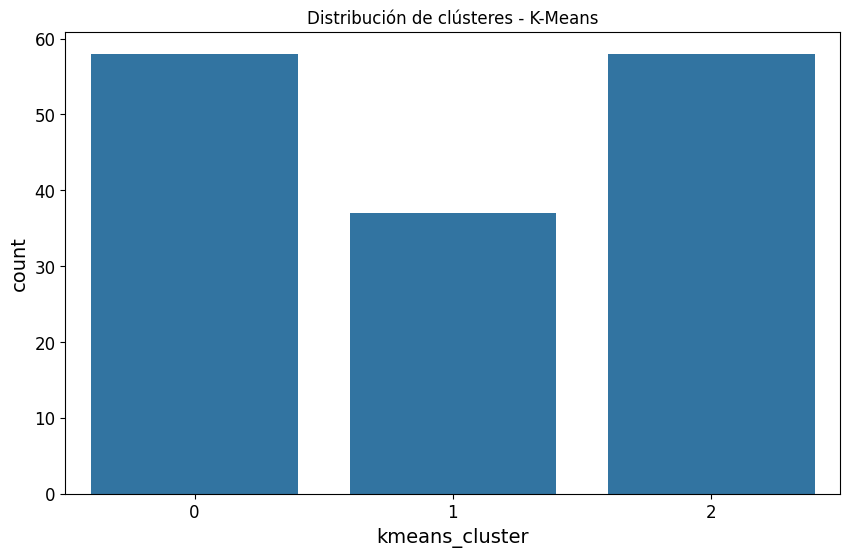

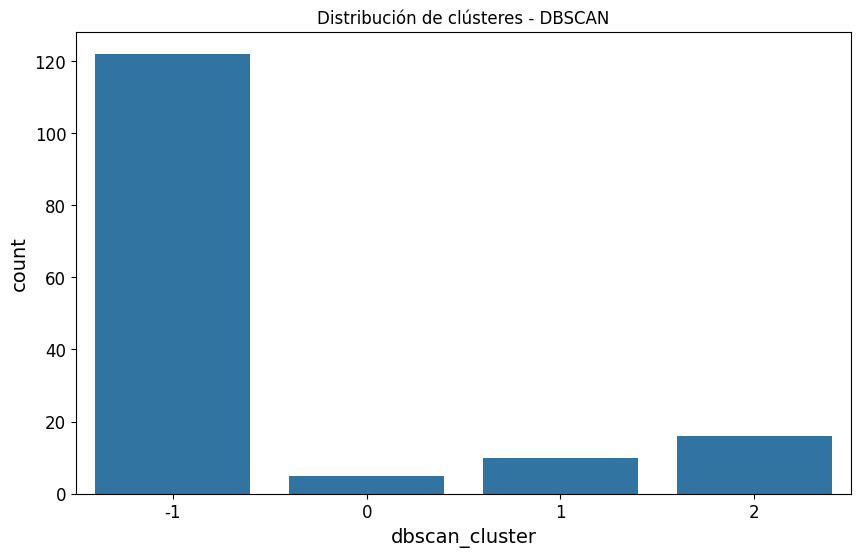

In [17]:
# Comparar número de clústeres y su distribución
print(f"K-Means: {len(set(kmeans_labels))} clusters")
print(f"DBSCAN: {len(set(dbscan_labels))} clusters (incluyendo ruido)")

# Añadir las etiquetas de clústeres al DataFrame original
df['kmeans_cluster'] = kmeans_labels
df['dbscan_cluster'] = dbscan_labels

# Mostrar distribución de clústeres
print(df['kmeans_cluster'].value_counts())
print(df['dbscan_cluster'].value_counts())

# Visualizar distribución de clústeres
plt.figure(figsize=(10, 6))
sns.countplot(x='kmeans_cluster', data=df)
plt.title('Distribución de clústeres - K-Means')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='dbscan_cluster', data=df)
plt.title('Distribución de clústeres - DBSCAN')
plt.show()


K-Means identifica 3 clústeres, con una distribución de 58, 58 y 37 observaciones en cada uno de los clústeres respectivamente.

DBSCAN identifica 4 clústeres, incluyendo puntos de ruido. La distribución de las observaciones en estos clústeres es la siguiente: 123 observaciones se etiquetaron como ruido (-1), mientras que los otros clústeres tienen 15, 10 y 5 observaciones respectivamente.

Estos resultados resaltan algunas diferencias clave entre los dos algoritmos:

Número de Clústeres:

K-Means requiere que especifiques el número de clústeres de antemano, mientras que DBSCAN puede determinar automáticamente el número de clústeres en función de la densidad de los datos.
En este caso, K-Means identifica 3 clústeres mientras que DBSCAN identifica 4, incluyendo el clúster de ruido.
Distribución de Observaciones:

La distribución de las observaciones entre los clústeres es más equilibrada en K-Means, mientras que en DBSCAN la mayoría de las observaciones se asignan al clúster de ruido.

Repitamos con otra seleccion de variables.Seleccionamos solo las variables "Azúcares" y "Ácido Cítrico" para realizar el clustering.

For n_clusters = 3, the average silhouette score is: 0.45723179629328925
For eps = 0.7 and min_samples = 5, the average silhouette score is: -1


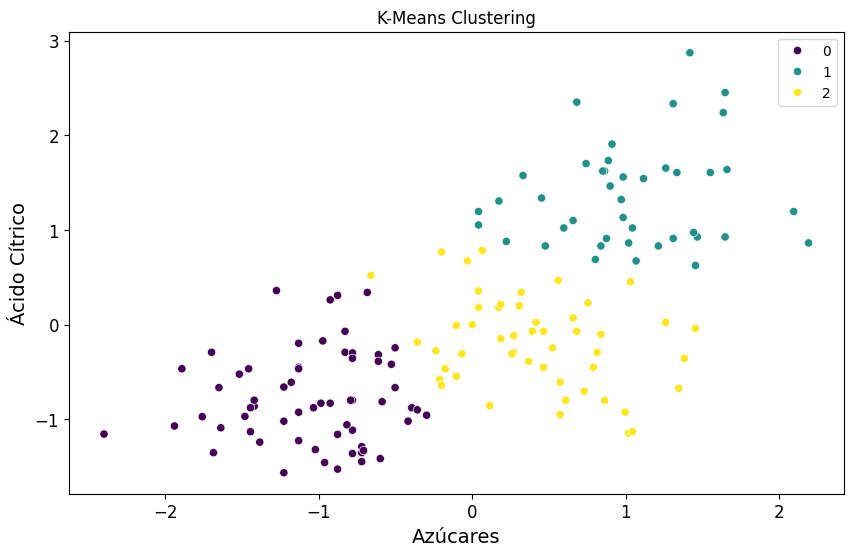

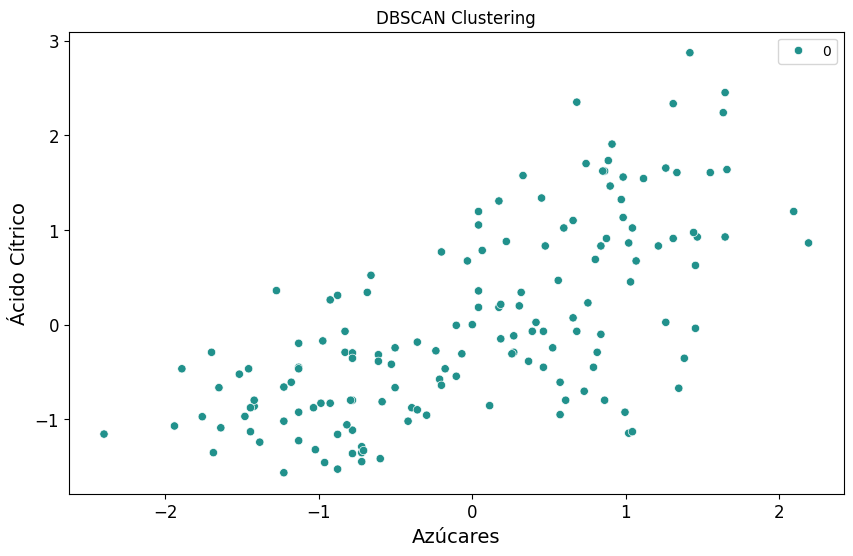

K-Means: 3 clusters
DBSCAN: 1 clusters (incluyendo ruido)
kmeans_cluster_selected
0    61
2    50
1    42
Name: count, dtype: int64
dbscan_cluster_selected
0    153
Name: count, dtype: int64


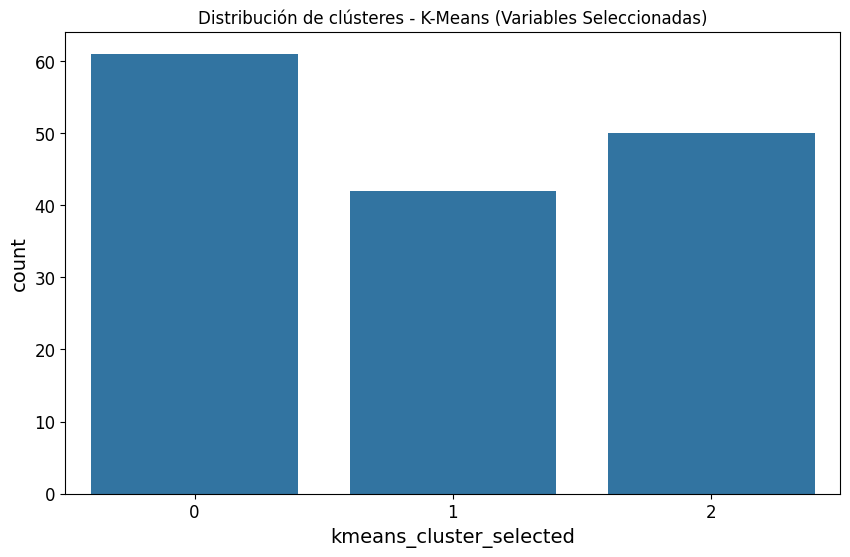

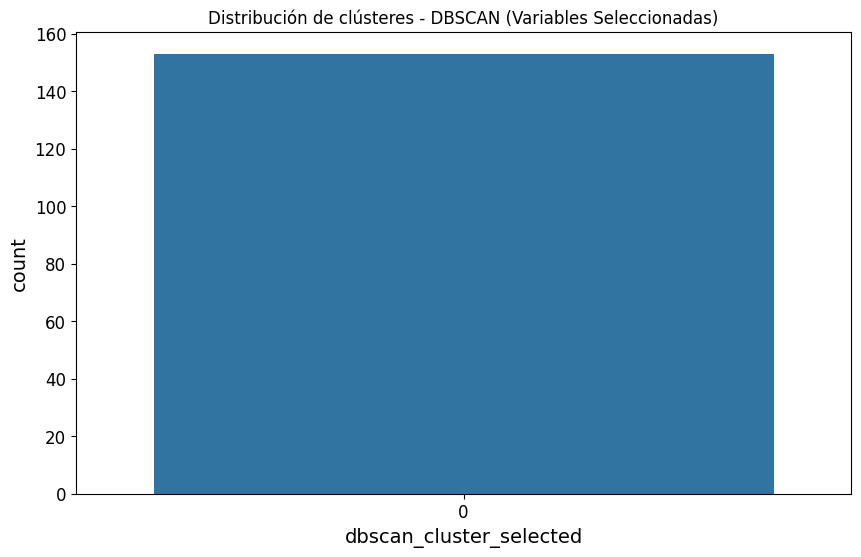

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score



# Seleccionar las variables más relevantes
selected_features = df[['Azúcares', 'Ácido Cítrico']]

# Escalar los datos
scaler = StandardScaler()
selected_features_scaled = scaler.fit_transform(selected_features)

# Convertir a DataFrame para un mejor manejo
selected_features_scaled = pd.DataFrame(selected_features_scaled, columns=selected_features.columns)

# Entrenar K-Means con las variables seleccionadas
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(selected_features_scaled)

# Calcular el puntaje silhouette
kmeans_silhouette = silhouette_score(selected_features_scaled, kmeans_labels)
print(f"For n_clusters = {n_clusters}, the average silhouette score is: {kmeans_silhouette}")

# Entrenar DBSCAN con las variables seleccionadas
eps = 0.7
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(selected_features_scaled)

# Calcular el puntaje silhouette
dbscan_silhouette = silhouette_score(selected_features_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
print(f"For eps = {eps} and min_samples = {min_samples}, the average silhouette score is: {dbscan_silhouette}")

# Visualización de los resultados de K-Means
plt.figure(figsize=(10, 6))
sns.scatterplot(x=selected_features_scaled['Azúcares'], y=selected_features_scaled['Ácido Cítrico'], hue=kmeans_labels, palette='viridis', legend='full')
plt.title('K-Means Clustering')
plt.xlabel('Azúcares')
plt.ylabel('Ácido Cítrico')
plt.show()

# Visualización de los resultados de DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(x=selected_features_scaled['Azúcares'], y=selected_features_scaled['Ácido Cítrico'], hue=dbscan_labels, palette='viridis', legend='full')
plt.title('DBSCAN Clustering')
plt.xlabel('Azúcares')
plt.ylabel('Ácido Cítrico')
plt.show()

# Comparar número de clústeres y su distribución
print(f"K-Means: {len(set(kmeans_labels))} clusters")
print(f"DBSCAN: {len(set(dbscan_labels))} clusters (incluyendo ruido)")

# Añadir las etiquetas de clústeres al DataFrame original
df['kmeans_cluster_selected'] = kmeans_labels
df['dbscan_cluster_selected'] = dbscan_labels

# Mostrar distribución de clústeres
print(df['kmeans_cluster_selected'].value_counts())
print(df['dbscan_cluster_selected'].value_counts())

# Visualizar distribución de clústeres
plt.figure(figsize=(10, 6))
sns.countplot(x='kmeans_cluster_selected', data=df)
plt.title('Distribución de clústeres - K-Means (Variables Seleccionadas)')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='dbscan_cluster_selected', data=df)
plt.title('Distribución de clústeres - DBSCAN (Variables Seleccionadas)')
plt.show()



K-Means Clustering:

Número de clústeres: 3 clústeres.
Silhouette Score: 0.4572, lo que indica una separación razonable entre los clústeres.
Distribución de las observaciones:
Clúster 0: 61 observaciones.
Clúster 1: 42 observaciones.
Clúster 2: 50 observaciones.
DBSCAN Clustering:

Número de clústeres: 1 clúster (incluyendo ruido).
Silhouette Score: -1, lo que indica que DBSCAN no identificó clústeres bien definidos.
Distribución de las observaciones:
Todas las 153 observaciones se asignaron a un único clúster, lo que sugiere que DBSCAN no encontró clústeres densos con los parámetros eps=0.7 y min_samples=5.

Repetiremos el ejercicio de clustering utilizando las variables "Cafeína" y "Taurina".

In [21]:
# Seleccionar las variables más relevantes
selected_features = df[['Cafeína', 'Taurina']]

# Escalar los datos
scaler = StandardScaler()
selected_features_scaled = scaler.fit_transform(selected_features)

# Convertir a DataFrame para un mejor manejo
selected_features_scaled = pd.DataFrame(selected_features_scaled, columns=selected_features.columns)


In [22]:
# Entrenar K-Means con las variables seleccionadas
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(selected_features_scaled)

# Calcular el puntaje silhouette
kmeans_silhouette = silhouette_score(selected_features_scaled, kmeans_labels)
print(f"For n_clusters = {n_clusters}, the average silhouette score is: {kmeans_silhouette}")


For n_clusters = 3, the average silhouette score is: 0.5096730453109849


In [23]:
# Entrenar DBSCAN con las variables seleccionadas
eps = 0.7
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(selected_features_scaled)

# Calcular el puntaje silhouette
dbscan_silhouette = silhouette_score(selected_features_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
print(f"For eps = {eps} and min_samples = {min_samples}, the average silhouette score is: {dbscan_silhouette}")


For eps = 0.7 and min_samples = 5, the average silhouette score is: 0.3942013562703098


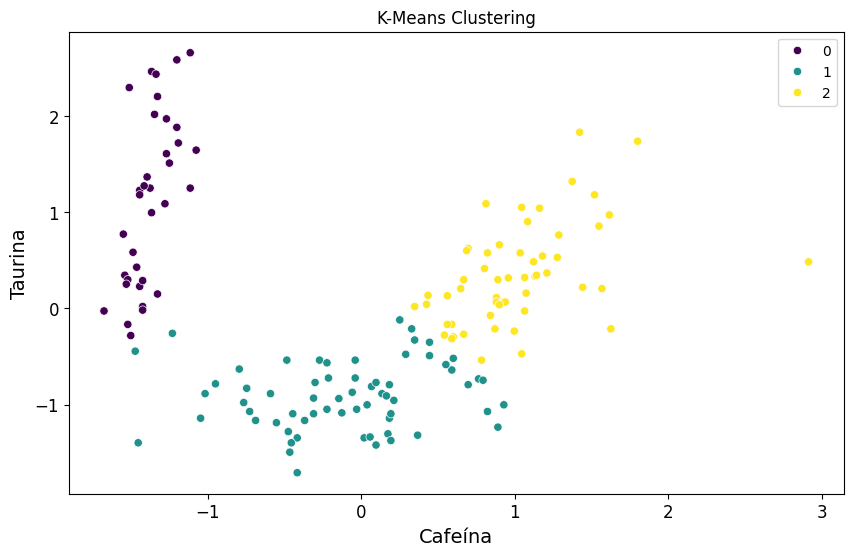

In [24]:
# Visualización de los resultados de K-Means
plt.figure(figsize=(10, 6))
sns.scatterplot(x=selected_features_scaled['Cafeína'], y=selected_features_scaled['Taurina'], hue=kmeans_labels, palette='viridis', legend='full')
plt.title('K-Means Clustering')
plt.xlabel('Cafeína')
plt.ylabel('Taurina')
plt.show()


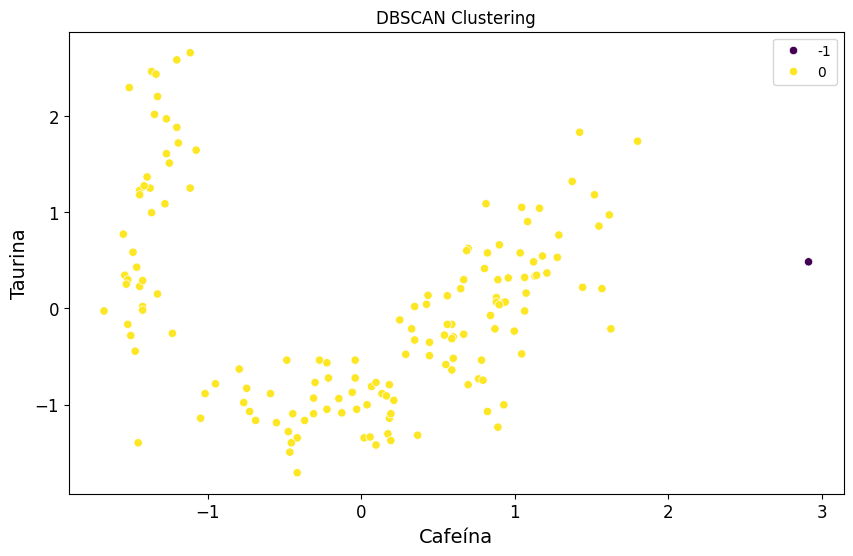

In [25]:
# Visualización de los resultados de DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(x=selected_features_scaled['Cafeína'], y=selected_features_scaled['Taurina'], hue=dbscan_labels, palette='viridis', legend='full')
plt.title('DBSCAN Clustering')
plt.xlabel('Cafeína')
plt.ylabel('Taurina')
plt.show()


K-Means: 3 clusters
DBSCAN: 2 clusters (incluyendo ruido)
kmeans_cluster_selected
1    64
2    54
0    35
Name: count, dtype: int64
dbscan_cluster_selected
 0    152
-1      1
Name: count, dtype: int64


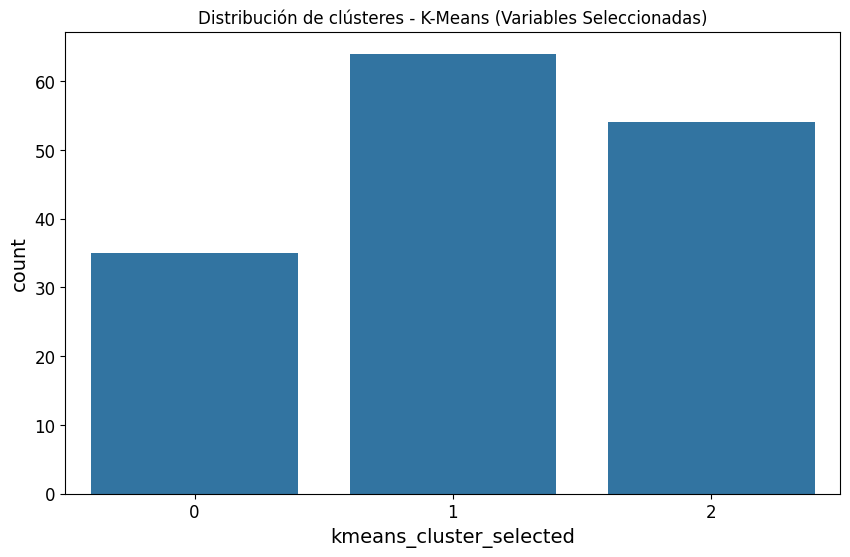

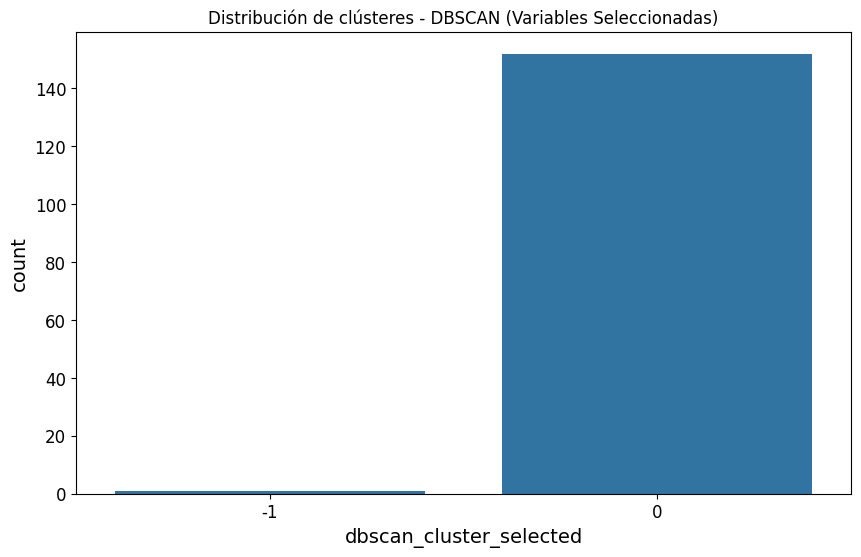

In [26]:
# Comparar número de clústeres y su distribución
print(f"K-Means: {len(set(kmeans_labels))} clusters")
print(f"DBSCAN: {len(set(dbscan_labels))} clusters (incluyendo ruido)")

# Añadir las etiquetas de clústeres al DataFrame original
df['kmeans_cluster_selected'] = kmeans_labels
df['dbscan_cluster_selected'] = dbscan_labels

# Mostrar distribución de clústeres
print(df['kmeans_cluster_selected'].value_counts())
print(df['dbscan_cluster_selected'].value_counts())

# Visualizar distribución de clústeres
plt.figure(figsize=(10, 6))
sns.countplot(x='kmeans_cluster_selected', data=df)
plt.title('Distribución de clústeres - K-Means (Variables Seleccionadas)')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='dbscan_cluster_selected', data=df)
plt.title('Distribución de clústeres - DBSCAN (Variables Seleccionadas)')
plt.show()



K-Means parece ser más efectivo para segmentar las mezclas de bebidas energéticas basándose en las características "Cafeína" y "Taurina". La segmentación es clara y balanceada entre los clústeres.
DBSCAN no ha identificado clústeres útiles con los parámetros dados para estas características. Podría ser necesario ajustar los parámetros de DBSCAN o considerar otras técnicas de preprocesamiento para mejorar su desempeño.

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [29]:
# Cargar los datos de los nuevos experimentos
new_experiments_path = './data/new_experiments.csv'
new_experiments = pd.read_csv(new_experiments_path, sep='|')
new_experiments.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583


In [32]:


# Cargar los datos de los nuevos experimentos
new_experiments_path = './data/new_experiments.csv'
new_experiments = pd.read_csv(new_experiments_path, sep='|')

# Seleccionar las características relevantes (Cafeína y Taurina)
new_selected_features = new_experiments[['Cafeína', 'Taurina']]

# Escalar los nuevos datos usando el mismo StandardScaler
scaler = StandardScaler()
scaler.fit(selected_features)  # Ajustar el escalador en los datos originales para consistencia
new_selected_features_scaled = scaler.transform(new_selected_features)

# Convertir a DataFrame para un mejor manejo
new_selected_features_scaled = pd.DataFrame(new_selected_features_scaled, columns=new_selected_features.columns)

# Aplicar el modelo K-Means previamente entrenado
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(selected_features_scaled)  # Entrenar el modelo con los datos originales
new_kmeans_labels = kmeans.predict(new_selected_features_scaled)

# Añadir las etiquetas de clúster al DataFrame original
new_experiments['kmeans_cluster'] = new_kmeans_labels

# Guardar las predicciones en un archivo CSV
output_path = './data/new_experiments_with_clusters.csv'
new_experiments.to_csv(output_path, index=False)

print(f'Las predicciones se han guardado en {output_path}')


Las predicciones se han guardado en ./data/new_experiments_with_clusters.csv


### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

In [34]:
# Cargar los resultados de energización
power_results_path = './data/power_results.csv'
power_results = pd.read_csv(power_results_path, sep='|')
power_results.head()

,class
0,1
1,1
2,1
3,1
4,1


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

# Cargar el DataFrame original con los datos de las bebidas
df = pd.read_csv('./data/empowering_drinks.csv', sep='|')

# Escalar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Cafeína', 'Taurina']])

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

# Cargar los resultados de energización
power_results_path = './data/power_results.csv'
power_results = pd.read_csv(power_results_path, sep='|')

# Unir los resultados de energización con los datos originales y las etiquetas de clúster
df_with_clusters = df.copy()
df_with_clusters['kmeans_cluster'] = kmeans_labels
df_with_clusters['dbscan_cluster'] = dbscan_labels
df_with_clusters['power_results'] = power_results['class']

# Evaluar la efectividad de los clústeres
# Distribución de los niveles de energización en cada clúster de K-Means
kmeans_evaluation = df_with_clusters.groupby('kmeans_cluster')['power_results'].value_counts(normalize=True).unstack()
print("Evaluación K-Means:")
print(kmeans_evaluation)

# Distribución de los niveles de energización en cada clúster de DBSCAN
dbscan_evaluation = df_with_clusters.groupby('dbscan_cluster')['power_results'].value_counts(normalize=True).unstack()
print("Evaluación DBSCAN:")
print(dbscan_evaluation)


Evaluación K-Means:
power_results          1         2        3
kmeans_cluster                             
0                    NaN       NaN  1.00000
1               0.125000  0.843750  0.03125
2               0.888889  0.111111      NaN
Evaluación DBSCAN:
power_results          1         2         3
dbscan_cluster                              
-1                   NaN  1.000000       NaN
 0              0.368421  0.388158  0.243421


K-Means:

El clúster 0 de K-Means es muy preciso para agrupar bebidas con un nivel de energización alto (3).
El clúster 1 agrupa mayoritariamente bebidas con un nivel de energización medio-alto (2), pero también contiene bebidas de los niveles 1 y 3.
El clúster 2 agrupa mayoritariamente bebidas con un nivel de energización medio (1), con algunas bebidas del nivel 2.
K-Means muestra una buena correspondencia con los niveles de energización, con clústeres que agrupan bebidas de un solo nivel predominante.

DBSCAN:

El clúster -1 de DBSCAN contiene únicamente bebidas con un nivel de energización medio-alto (2), lo que muestra una correspondencia clara, aunque este es el único nivel que agrupa.
El clúster 0 de DBSCAN contiene una mezcla de niveles de energización, sin una clara predominancia de un solo nivel.

DBSCAN muestra una menor correspondencia con los niveles de energización, ya que sus clústeres contienen mezclas de diferentes niveles y no separa claramente las bebidas de acuerdo a su nivel de energización.

Conclusión
De acuerdo con los resultados de las evaluaciones, K-Means es más efectivo que DBSCAN para la segmentación de las bebidas en función de los niveles de energización. K-Means proporciona clústeres con una clara predominancia de un solo nivel de energización, lo que facilita la interpretación y uso práctico de los clústeres.